In [1]:
import sys
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Create output folders for reproducibility
os.makedirs("results", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# Plot style
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn_version)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1


In [2]:
DATA_PATH = "heart.csv"  # your CSV file

df = pd.read_csv(DATA_PATH)

print("Raw data shape:", df.shape)
df.head()


Raw data shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
print("Data info:")
df.info()

print("\nSummary statistics (numeric):")
display(df.describe())

print("\nTarget value counts:")
print(df["target"].value_counts())


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

Summary statistics (numeric):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000



Target value counts:
target
1    165
0    138
Name: count, dtype: int64


In [4]:
print("Missing values per column:")
print(df.isna().sum())

# For this project: simple strategy = drop rows with missing values
# (In a bigger project you might use more advanced imputation.)
df_clean = df.dropna().copy()

print("\nShape before dropna:", df.shape)
print("Shape after dropna:", df_clean.shape)

# Save cleaned dataset for reproducibility
df_clean.to_csv("artifacts/heart_clean.csv", index=False)
print("Cleaned data saved to artifacts/heart_clean.csv")


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Shape before dropna: (303, 14)
Shape after dropna: (303, 14)
Cleaned data saved to artifacts/heart_clean.csv


In [5]:
TARGET_COL = "target"

X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Features shape: (303, 13)
Target shape: (303,)

Numeric features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical features: []


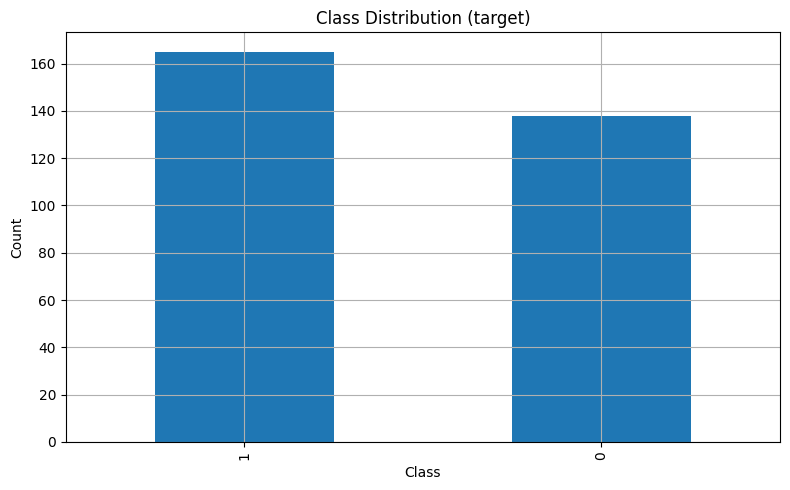

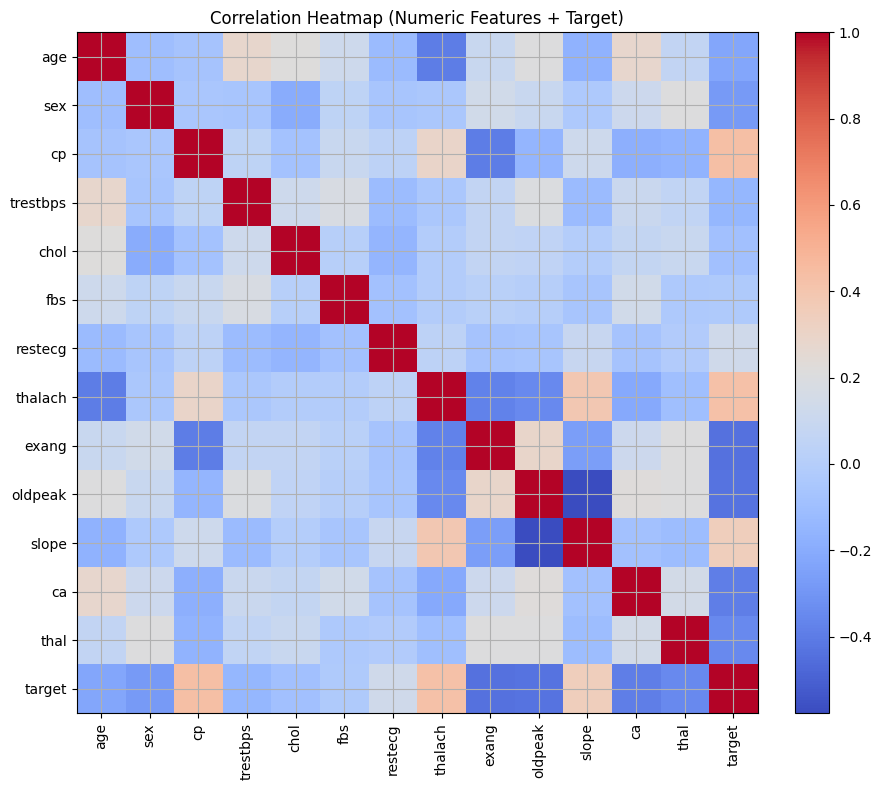

In [6]:
# Class balance
ax = y.value_counts().plot(kind="bar")
plt.title("Class Distribution (target)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/class_distribution.png", dpi=300)
plt.show()

# Correlation heatmap (numeric features + target)
df_corr = df_clean[numeric_features + [TARGET_COL]].corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(df_corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, rotation=90)
plt.yticks(range(df_corr.shape[1]), df_corr.columns)
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.tight_layout()
plt.savefig("figures/correlation_heatmap.png", dpi=300)
plt.show()


In [9]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain class balance:")
print(y_train.value_counts(normalize=True))
print("\nTest class balance:")
print(y_test.value_counts(normalize=True))


Train shape: (242, 13) Test shape: (61, 13)

Train class balance:
target
1    0.545455
0    0.454545
Name: proportion, dtype: float64

Test class balance:
target
1    0.540984
0    0.459016
Name: proportion, dtype: float64


In [10]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                                  'restecg', 'thalach', 'exang', 'oldpeak',
                                  'slope', 'ca', 'thal']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

In [11]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample"
)

log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_clf)
])

models = {
    "Logistic Regression": log_reg_pipeline,
    "Random Forest": rf_pipeline
}

models


{'Logistic Regression': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'sex', 'cp',
                                                    'trestbps', 'chol', 'fbs',
                                                    'restecg', 'thalach',
                                                    'exang', 'oldpeak', 'slope',
                                                    'ca', 'thal']),
                                                  ('cat',
                                                   Pipeline(steps=[('onehot',
                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                   [])])),
                 ('model',
           

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_results = {}

for name, pipe in models.items():
    print(f"\n=== {name} ===")
    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    cv_results[name] = scores

    for metric in scoring.keys():
        mean_score = scores[f"test_{metric}"].mean()
        std_score = scores[f"test_{metric}"].std()
        print(f"{metric.upper()}: {mean_score:.3f} ± {std_score:.3f}")

# Save CV results (per-fold) to CSV for reproducibility
rows = []
for name, scores in cv_results.items():
    for i in range(len(scores["test_accuracy"])):
        rows.append({
            "model": name,
            "fold": i,
            "accuracy": scores["test_accuracy"][i],
            "f1": scores["test_f1"][i],
            "roc_auc": scores["test_roc_auc"][i]
        })
cv_df = pd.DataFrame(rows)
cv_df.to_csv("results/cv_results.csv", index=False)
print("\nCross-validation results saved to results/cv_results.csv")



=== Logistic Regression ===
ACCURACY: 0.810 ± 0.097
F1: 0.826 ± 0.096
ROC_AUC: 0.889 ± 0.061

=== Random Forest ===
ACCURACY: 0.801 ± 0.078
F1: 0.826 ± 0.064
ROC_AUC: 0.881 ± 0.062

Cross-validation results saved to results/cv_results.csv


In [13]:
from copy import deepcopy

test_metrics = {}
all_cm = {}
fitted_models = {}   # <- NEW: will hold the fitted pipelines

for name, pipe in models.items():
    print(f"\n============================")
    print(f"Training & Evaluating: {name}")
    print("============================")

    # Make a copy just in case, then fit
    model_clone = deepcopy(pipe)
    model_clone.fit(X_train, y_train)
    fitted_models[name] = model_clone   # <- store fitted pipeline

    y_pred = model_clone.predict(X_test)

    if hasattr(model_clone.named_steps["model"], "predict_proba"):
        y_proba = model_clone.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = np.nan

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    test_metrics[name] = {"accuracy": acc, "f1": f1, "roc_auc": roc_auc}

    print(f"Test Accuracy : {acc:.3f}")
    print(f"Test F1-score : {f1:.3f}")
    print(f"Test ROC-AUC  : {roc_auc:.3f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    all_cm[name] = cm
    print("Confusion Matrix:\n", cm)

# Save test metrics
tm_rows = []
for name, m in test_metrics.items():
    row = {"model": name}
    row.update(m)
    tm_rows.append(row)
test_metrics_df = pd.DataFrame(tm_rows)
test_metrics_df.to_csv("results/test_metrics.csv", index=False)
print("\nTest metrics saved to results/test_metrics.csv")



Training & Evaluating: Logistic Regression
Test Accuracy : 0.787
Test F1-score : 0.817
Test ROC-AUC  : 0.871

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.78        61

Confusion Matrix:
 [[19  9]
 [ 4 29]]

Training & Evaluating: Random Forest
Test Accuracy : 0.803
Test F1-score : 0.838
Test ROC-AUC  : 0.903

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61

Confusion Matrix:
 [[18 10]
 [ 2 31]]

Test me

<Figure size 800x500 with 0 Axes>

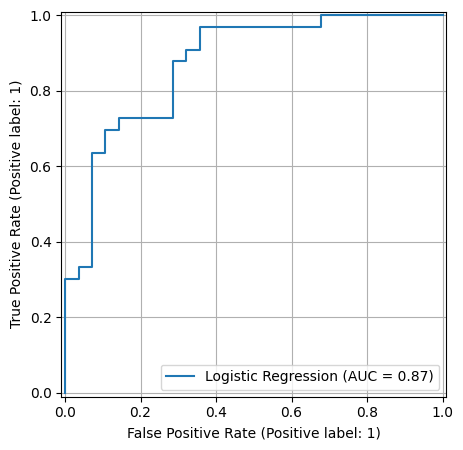

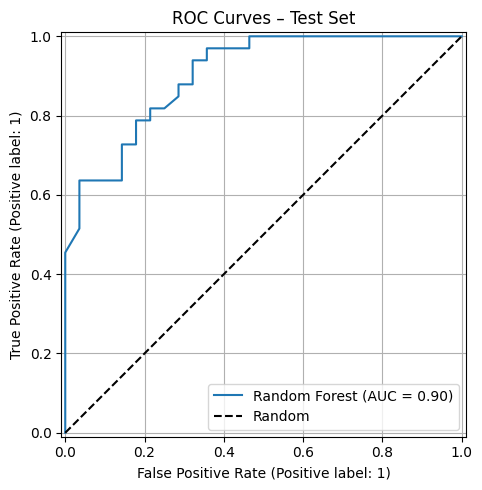

In [17]:
plt.figure()

for name, pipe in models.items():
    # fit each pipeline on training data before ROC
    pipe.fit(X_train, y_train)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        RocCurveDisplay.from_predictions(
            y_test,
            y_proba,
            name=name
        )

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves – Test Set")
plt.legend()
plt.tight_layout()
plt.savefig("figures/roc_curves.png", dpi=300)
plt.show()


In [18]:
# Make sure Cell 12 has been run first!

log_reg_fitted = fitted_models["Logistic Regression"]  # <- use fitted pipeline

# Get feature names after preprocessing
ohe = log_reg_fitted.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]

if categorical_features:
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_feature_names])
else:
    feature_names = np.array(numeric_features)

coefs = log_reg_fitted.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", ascending=False)

coef_df.to_csv("results/log_reg_coefficients.csv", index=False)
print("Logistic regression coefficients saved to results/log_reg_coefficients.csv")

print("Top positive coefficients (higher risk):")
display(coef_df.head(10))

print("\nTop negative coefficients (lower risk):")
display(coef_df.tail(10))


Logistic regression coefficients saved to results/log_reg_coefficients.csv
Top positive coefficients (higher risk):


,feature,coefficient
2,cp,0.936240
7,thalach,0.557740
10,slope,0.317276
6,restecg,0.226912
0,age,0.008173
5,fbs,-0.064743
3,trestbps,-0.205712
8,exang,-0.466045
4,chol,-0.485082
11,ca,-0.565212



Top negative coefficients (lower risk):


,feature,coefficient
6,restecg,0.226912
0,age,0.008173
5,fbs,-0.064743
3,trestbps,-0.205712
8,exang,-0.466045
4,chol,-0.485082
11,ca,-0.565212
9,oldpeak,-0.584661
12,thal,-0.620505
1,sex,-0.739688


In [20]:
# Cell: Fit final models on training data

# Make sure these exist already in earlier cells:
# - log_reg_pipeline
# - rf_pipeline
# - X_train, y_train

log_reg_fitted = log_reg_pipeline.fit(X_train, y_train)
rf_fitted = rf_pipeline.fit(X_train, y_train)

print("Fitted Logistic Regression and Random Forest on training data.")


Fitted Logistic Regression and Random Forest on training data.


Confusion matrices saved to: figures/confusion_matrices.png


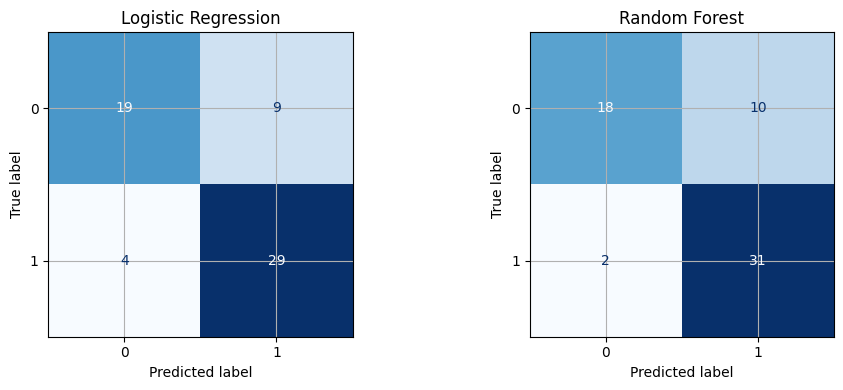

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Make sure the figures folder exists
os.makedirs("figures", exist_ok=True)

# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Logistic Regression confusion matrix
ConfusionMatrixDisplay.from_estimator(
    log_reg_fitted,
    X_test,
    y_test,
    ax=axes[0],
    cmap="Blues",
    colorbar=False
)
axes[0].set_title("Logistic Regression")

# Random Forest confusion matrix
ConfusionMatrixDisplay.from_estimator(
    rf_fitted,
    X_test,
    y_test,
    ax=axes[1],
    cmap="Blues",
    colorbar=False
)
axes[1].set_title("Random Forest")

plt.tight_layout()

conf_mat_path = "figures/confusion_matrices.png"
plt.savefig(conf_mat_path, dpi=300, bbox_inches="tight")

print(f"Confusion matrices saved to: {conf_mat_path}")
plt.show()


Random Forest feature importances saved to results/random_forest_importances.csv


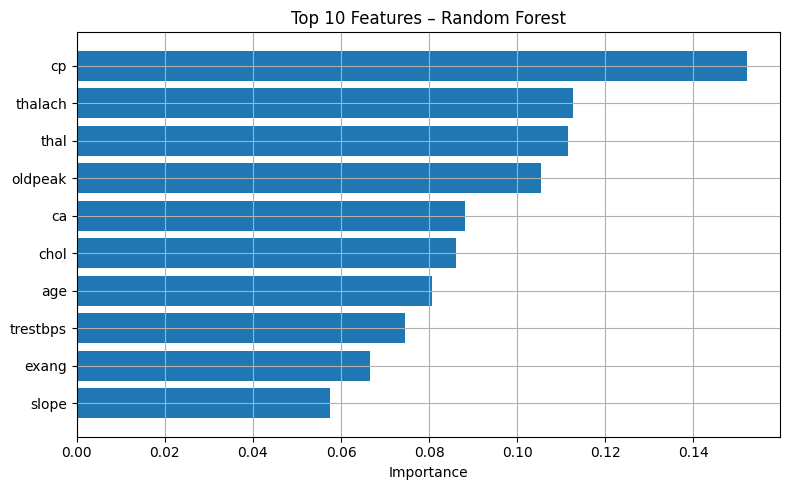

In [22]:
rf_fitted = models["Random Forest"]
rf_importances = rf_fitted.named_steps["model"].feature_importances_

rf_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values(by="importance", ascending=False)

rf_imp_df.to_csv("results/random_forest_importances.csv", index=False)
print("Random Forest feature importances saved to results/random_forest_importances.csv")

top_n = 10
top_rf = rf_imp_df.head(top_n).sort_values(by="importance")

plt.barh(top_rf["feature"], top_rf["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features – Random Forest")
plt.tight_layout()
plt.savefig("figures/rf_top_features.png", dpi=300)
plt.show()


In [23]:
print("=== Cross-Validation (Train) Summary ===")
for name, scores in cv_results.items():
    print(f"\n{name}:")
    for metric in ["accuracy", "f1", "roc_auc"]:
        mean_score = scores[f"test_{metric}"].mean()
        std_score = scores[f"test_{metric}"].std()
        print(f"  {metric.upper()}: {mean_score:.3f} ± {std_score:.3f}")

print("\n=== Test Set Summary ===")
for name, metrics in test_metrics.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric.upper()}: {value:.3f}")


=== Cross-Validation (Train) Summary ===

Logistic Regression:
  ACCURACY: 0.810 ± 0.097
  F1: 0.826 ± 0.096
  ROC_AUC: 0.889 ± 0.061

Random Forest:
  ACCURACY: 0.801 ± 0.078
  F1: 0.826 ± 0.064
  ROC_AUC: 0.881 ± 0.062

=== Test Set Summary ===

Logistic Regression:
  ACCURACY: 0.787
  F1: 0.817
  ROC_AUC: 0.871

Random Forest:
  ACCURACY: 0.803
  F1: 0.838
  ROC_AUC: 0.903


In [24]:
ai_usage_notes = """
AI Usage Notes (for ai_usage.md and report):

- Large language models (e.g., ChatGPT) were used to:
  * Suggest code structure for the ML workflow (EDA, preprocessing, model training).
  * Help with phrasing of documentation and comments.
- All code was reviewed, executed, and debugged by the author.
- All numerical results (metrics, plots) are produced by running the notebook locally.
- No patient-identifying information is included; data is a public benchmark dataset.
"""

with open("ai_usage_notes.txt", "w") as f:
    f.write(ai_usage_notes)

print("AI usage notes saved to ai_usage_notes.txt (copy/adapt into ai_usage.md)")


AI usage notes saved to ai_usage_notes.txt (copy/adapt into ai_usage.md)
